#Name: Omid Jafaei

#Student ID: 401204268

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#قسمت الف

1- Unlike VAEs, which use continuous latent variables, the VQ-VAE employs discrete latent variables. These discrete latent variables are obtained by a nearest neighbor look-up in an embedding space, which is inspired by vector quantization (VQ) . This allows for a more structured and interpretable representation of the data.

2- In VQ-VAE, the prior distribution is learned rather than being static. This means that the model can adapt its prior based on the specific data it is trained on, leading to more flexible and data-dependent representations.

3- VQ-VAE addresses the "posterior collapse" issue that has been problematic in many VAE models with powerful decoders. This issue is often caused by latents being ignored, and the VQ-VAE's use of discrete latent variables helps mitigate this problem.

4- VQ-VAE can successfully model important features that span many dimensions in data space, such as objects in images or phonemes in speech, while avoiding spending capacity on noise and imperceptible details.

5- The VQ-VAE model achieves similar performance to its continuous counterparts in terms of log-likelihood, while offering the flexibility and interpretability of discrete distributions.

#قسمت ب

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 81677149.93it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 97532764.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33379626.32it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17287231.19it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
data_variance = np.var(train_dataset.data.numpy()/ 255.0)

In [ ]:
batch_size=256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#قسمت ج

In [ ]:
class CodeBook(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta):
        super(CodeBook, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
        self.beta = beta

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        flat_input = inputs.view(-1, self.embedding_dim)

        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) - 2 * torch.matmul(flat_input, self.embedding.weight.t()) + torch.sum(self.embedding.weight**2, dim=1))


        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

        e_latent_loss = F.mse_loss(quantized.detach(), inputs)  #
        q_latent_loss = F.mse_loss(quantized, inputs.detach())  # Special Losses of VQ-VAE are calculated here.
        loss = q_latent_loss + self.beta * e_latent_loss        #

        quantized = inputs + (quantized - inputs).detach()

        return loss, quantized.permute(0, 3, 1, 2).contiguous()

In [ ]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, num_residual_hiddens):
        super(Residual, self).__init__()
        self.block = nn.Sequential(nn.ReLU(),
                                   nn.Conv2d(in_channels=in_channels,
                                             out_channels=num_residual_hiddens,
                                             kernel_size=3, stride=1, padding=1, bias=False),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=num_residual_hiddens,
                                             out_channels=out_channels,
                                             kernel_size=1, stride=1, bias=False)
                                   )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class Encoder(nn.Module):

    def __init__(self, input_channels):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=4, stride=2, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1),
                                      nn.ReLU(),
                                      Residual(in_channels=8, out_channels=8, num_residual_hiddens=8),
                                      Residual(in_channels=8, out_channels=8, num_residual_hiddens=8),
                                      nn.ReLU()
                                    )

    def forward(self, x):
        return self.encoder(x)

In [ ]:
class Decoder(nn.Module):

    def __init__(self, output_channels):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
                                     Residual(in_channels=16, out_channels=16, num_residual_hiddens=16),
                                     Residual(in_channels=16, out_channels=16, num_residual_hiddens=16),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(in_channels=16, out_channels=32,kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(in_channels=32, out_channels=output_channels, kernel_size=4,stride=2, padding=1)
                                     )

    def forward(self, x):
        return self.decoder(x)

In [ ]:
class Model(nn.Module):
    def __init__(self, image_channels, num_hiddens, num_embeddings, embedding_dim, beta):
        super(Model, self).__init__()

        self.encoder = Encoder(input_channels=image_channels)

        self.pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1, stride=1)

        self.vq_vae = CodeBook(num_embeddings, embedding_dim, beta)

        self.post_vq_conv = nn.Conv2d(in_channels=embedding_dim, out_channels=num_hiddens, kernel_size=1, stride=1)

        self.decoder = Decoder(output_channels=image_channels)

    def forward(self, x):
        z = self.encoder(x)
        z = self.pre_vq_conv(z)
        loss, quantized = self.vq_vae(z)
        z = self.post_vq_conv(quantized)
        x_recon = self.decoder(z)

        return loss, x_recon, quantized

#قسمت د

In [ ]:
def train_VQ_VAE(model, train_loader, epochs):
    model.train()
    batch_loss = []
    total_loss = []
    counter = 0
    learning_rate = 1e-3
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
    for i in range(0, epochs):
      with tqdm(train_loader, desc=f'Epoch {i + 1}/{epochs}', unit='batch', leave=False) as epoch_progress:
        for batch_idx, (data, _) in enumerate(epoch_progress):
            data = data.to(device)
            optimizer.zero_grad()

            vq_loss, data_recon, quantized = model(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()

            batch_loss.append(loss.item())

            if batch_idx % 8 == 0:
              plt.figure()
              plt.scatter(model.vq_vae.embedding.weight[:,0].cpu().detach().numpy(), model.vq_vae.embedding.weight[:,1].cpu().detach().numpy())
              plt.title('VQ-VAE Embeddings Visualization During Training')
              plt.xlabel('Dimension 1')
              plt.ylabel('Dimension 2')
              plt.xlim(-3,3)
              plt.ylim(-3,3)
              plt.savefig(f'embedding{counter}.png')
              plt.close()
              counter+=1
        total_loss.append(float(sum(batch_loss)/len(batch_loss)))
    plt.plot(total_loss, '-o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss of Different Epochs')


#قسمت و

In [ ]:
embedding_dim = 2
num_embeddings = 3
beta = 0.25

model = Model(image_channels=1,
              num_hiddens=8,
              num_embeddings=num_embeddings,
              embedding_dim=embedding_dim,
              beta=beta).to(device)

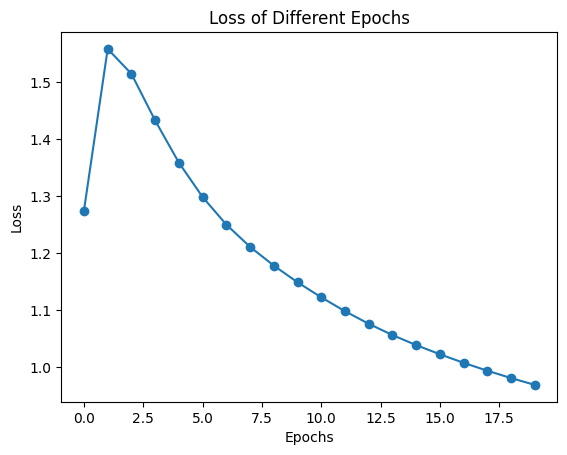

In [ ]:
train_VQ_VAE(model=model, train_loader=train_loader, epochs=20)

#قسمت ز

In [ ]:
val_batch_size = 16
val_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)

In [ ]:
model.eval()

(valid_originals, _) = next(iter(val_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model.pre_vq_conv(model.encoder(valid_originals))
_, valid_quantize = model.vq_vae(vq_output_eval)
valid_post_quantize = model.post_vq_conv(valid_quantize)
valid_reconstructions = model.decoder(valid_post_quantize)

Text(0.5, 1.0, 'Reconstructed Images')

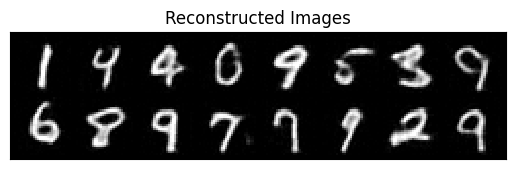

In [ ]:
npimg = make_grid(valid_reconstructions.cpu().data).numpy()
fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('Reconstructed Images')

Text(0.5, 1.0, 'Original Images')

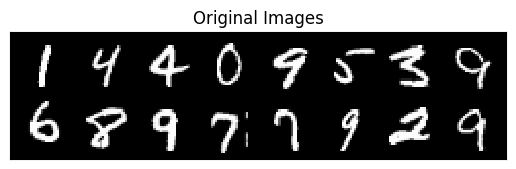

In [ ]:
npimg = make_grid(valid_originals.cpu().data).numpy()
fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('Original Images')

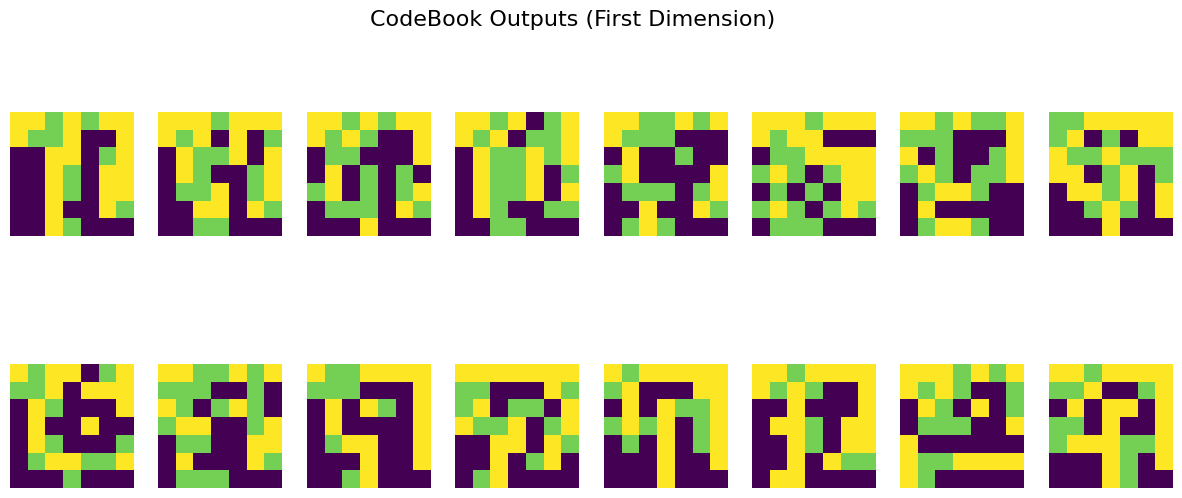

In [ ]:
batch_to_plot = valid_quantize[:, 0, :, :]

fig, axes = plt.subplots(2, int(val_batch_size/2), figsize=(15, 6))

for i in range(batch_to_plot.shape[0]):
    slice_to_plot = batch_to_plot[i, :, :].cpu().detach().numpy()
    axes[i // int(val_batch_size/2), i % int(val_batch_size/2)].imshow(slice_to_plot, extent=[0, 1, 0, 1])
    axes[i // val_batch_size, i % int(val_batch_size/2)].get_xaxis().set_visible(False)
    axes[i // int(val_batch_size/2), i % int(val_batch_size/2)].get_yaxis().set_visible(False)

for ax in axes.flatten():
    ax.axis('off')
plt.suptitle('CodeBook Outputs (First Dimension)', fontsize=16)
plt.show()

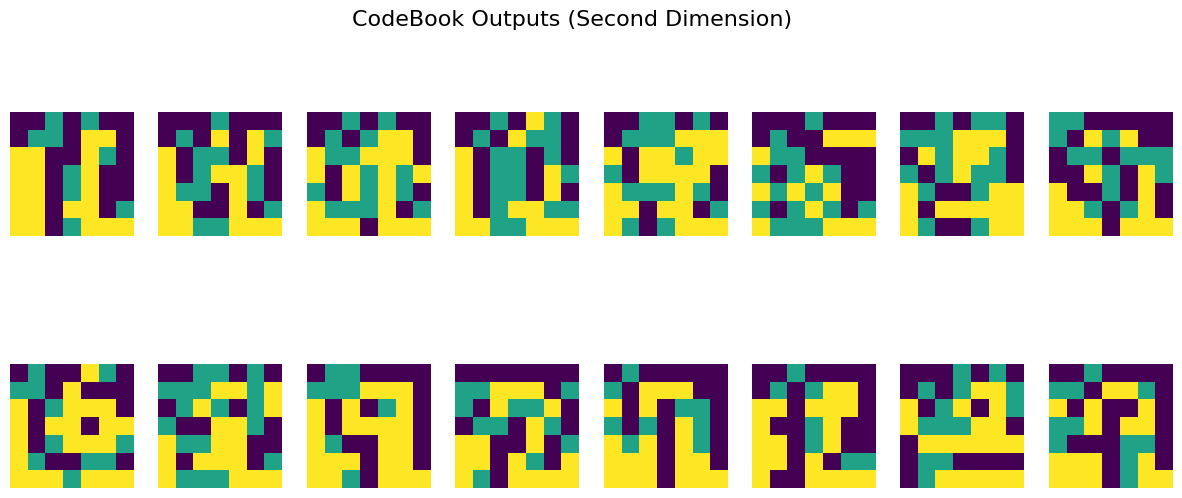

In [ ]:
batch_to_plot = valid_quantize[:, 1, :, :]

fig, axes = plt.subplots(2, int(val_batch_size/2), figsize=(15, 6))

for i in range(batch_to_plot.shape[0]):
    slice_to_plot = batch_to_plot[i, :, :].cpu().detach().numpy()
    axes[i // int(val_batch_size/2), i % int(val_batch_size/2)].imshow(slice_to_plot, extent=[0, 1, 0, 1])
    axes[i // val_batch_size, i % int(val_batch_size/2)].get_xaxis().set_visible(False)
    axes[i // int(val_batch_size/2), i % int(val_batch_size/2)].get_yaxis().set_visible(False)

for ax in axes.flatten():
    ax.axis('off')
plt.suptitle('CodeBook Outputs (Second Dimension)', fontsize=16)
plt.show()

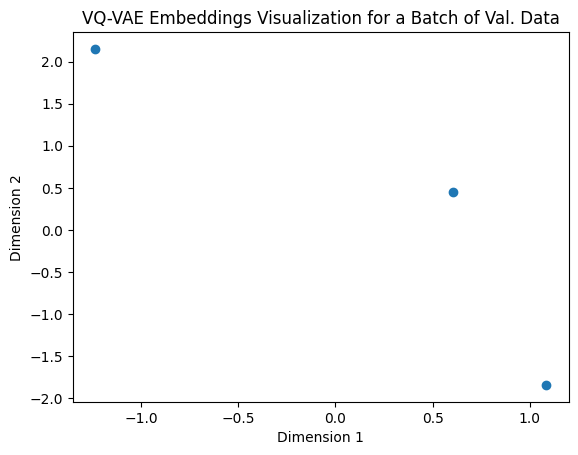

In [ ]:
plt.scatter(model.vq_vae.embedding.weight[:,0].cpu().detach().numpy(), model.vq_vae.embedding.weight[:,1].cpu().detach().numpy())
plt.title('VQ-VAE Embeddings Visualization for a Batch of Val. Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

#قسمت ح

In [ ]:
import glob
import re
from PIL import Image
import matplotlib.animation as animation


files = glob.glob("*.png")
files.sort(key=lambda x: int(re.search(r'\d+', x).group()))

image_array = []
for my_file in files:

    image = Image.open(my_file)
    image_array.append(image)

fig, ax = plt.subplots()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

im = ax.imshow(image_array[0], animated=True)
def update(i):
    im.set_array(image_array[i])
    return im,

animation_fig = animation.FuncAnimation(fig,
                                        update,
                                        frames=len(image_array),
                                        interval=100,
                                        blit=True,
                                        repeat_delay=5)

animation_fig.save("embeddings.gif")
plt.close()

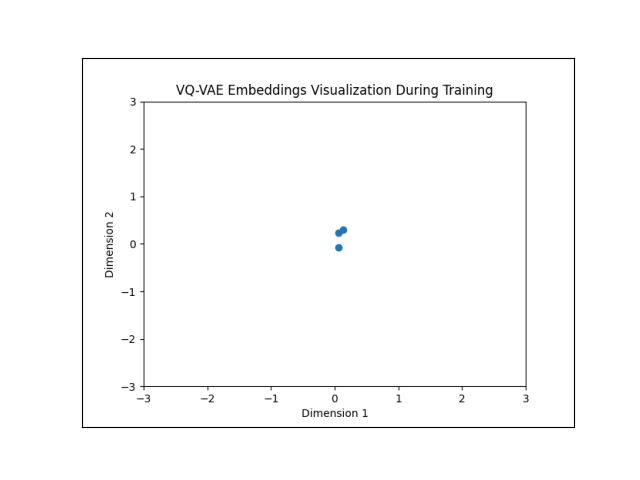

In [ ]:
import IPython
IPython.display.Image(open('embeddings.gif','rb').read())

#قسمت ط

##بخش اول

رنگی کردن و ساخت دیتاست رنگی، در تابع آموزش صورت می گیرد

In [ ]:
def train_VQ_VAE_RGB_MNIST(model, train_loader, epochs):
    model.train()
    batch_loss = []
    total_loss = []
    learning_rate = 1e-3
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
    for i in range(0, epochs):
      with tqdm(train_loader, desc=f'Epoch {i + 1}/{epochs}', unit='batch', leave=False) as epoch_progress:
        for batch_idx, (data, _) in enumerate(epoch_progress):

            image_rgb = torch.cat([data, data, data], dim=1)#
            multiplier = torch.rand(data.shape[0], 3, 1, 1) #
            image_rgb *= multiplier                         #coloring process
            image_rgb = torch.clamp(image_rgb, 0, 1)        #

            image_rgb = image_rgb.to(device)
            optimizer.zero_grad()

            vq_loss, data_recon, quantized = model(image_rgb)
            recon_error = F.mse_loss(data_recon, image_rgb) / data_variance
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()

            batch_loss.append(loss.item())

        total_loss.append(float(sum(batch_loss)/len(batch_loss)))
    plt.plot(range(epochs), total_loss, '-o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss of Different Epochs')


نمایش تعدادی از تصاویر رنگی:

In [ ]:
valid_originals = valid_originals.cpu()
image_rgb = torch.cat([valid_originals, valid_originals, valid_originals], dim=1)
multiplier = torch.rand(valid_originals.shape[0], 3, 1, 1)
image_rgb *= multiplier
image_rgb = torch.clamp(image_rgb, 0, 1)

image_rgb = image_rgb.to(device)

Text(0.5, 1.0, 'Original Colored Images')

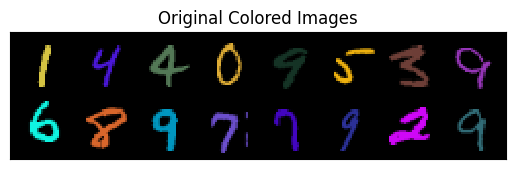

In [ ]:
npimg = make_grid(image_rgb.cpu().data).numpy()
fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('Original Colored Images')

##بخش دوم

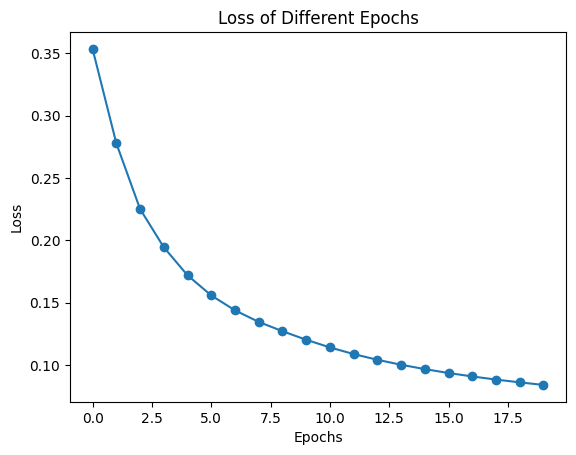

In [ ]:
embedding_dim = 2
num_embeddings = 70
beta = 0.25

model_rgb_high_embeddings = Model(image_channels=3,
              num_hiddens=8,
              num_embeddings=num_embeddings,
              embedding_dim=embedding_dim,
              beta=beta).to(device)

train_VQ_VAE_RGB_MNIST(model=model_rgb_high_embeddings, train_loader=train_loader, epochs=20)

In [ ]:
model_rgb_high_embeddings.eval()

image_rgb = image_rgb.to(device)

vq_output_eval = model_rgb_high_embeddings.pre_vq_conv(model_rgb_high_embeddings.encoder(image_rgb))
_, valid_quantize = model_rgb_high_embeddings.vq_vae(vq_output_eval)
valid_post_quantize = model_rgb_high_embeddings.post_vq_conv(valid_quantize)
valid_reconstructions = model_rgb_high_embeddings.decoder(valid_post_quantize)

Text(0.5, 1.0, 'Reconstructed Images')

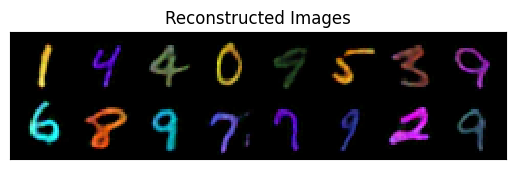

In [ ]:
npimg = make_grid(valid_reconstructions.cpu().data).numpy()
fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('Reconstructed Images')

Text(0.5, 1.0, 'Original Images')

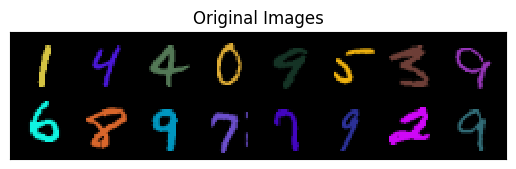

In [ ]:
npimg = make_grid(image_rgb.cpu().data).numpy()
fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('Original Images')

کیفیت تصاویر تولیدی بهبود سافته است و مدل جزئیات تصاویر را بهتر بازسازی می کند.


مشخصا تابع هزینه مدل بسیار کمتر شده است.


ولی در مقابل پیچیدگی محاسباتی و زمان آموزش مدل افزایش یافته است.

##بخش سوم

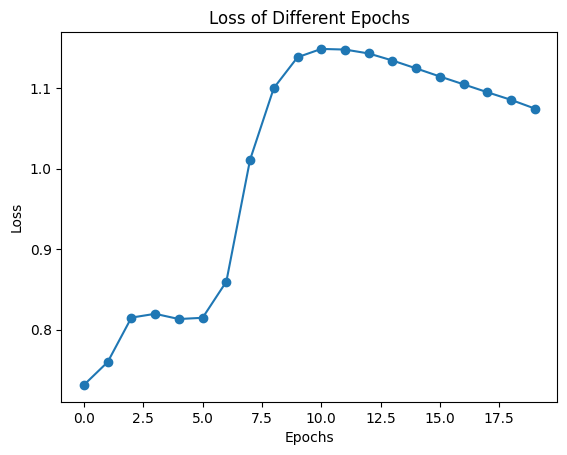

In [ ]:
embedding_dim = 70
num_embeddings = 3
beta = 0.25

model_rgb_high_dim = Model(image_channels=3,
              num_hiddens=8,
              num_embeddings=num_embeddings,
              embedding_dim=embedding_dim,
              beta=beta).to(device)

train_VQ_VAE_RGB_MNIST(model=model_rgb_high_dim, train_loader=train_loader, epochs=20)

In [ ]:
model_rgb_high_dim.eval()

image_rgb = image_rgb.to(device)

vq_output_eval = model_rgb_high_dim.pre_vq_conv(model_rgb_high_dim.encoder(image_rgb))
_, valid_quantize = model_rgb_high_dim.vq_vae(vq_output_eval)
valid_post_quantize = model_rgb_high_dim.post_vq_conv(valid_quantize)
valid_reconstructions = model_rgb_high_dim.decoder(valid_post_quantize)

Text(0.5, 1.0, 'Reconstructed Images')

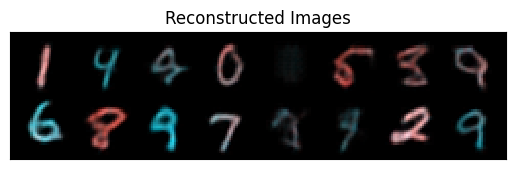

In [ ]:
npimg = make_grid(valid_reconstructions.cpu().data).numpy()
fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('Reconstructed Images')

Text(0.5, 1.0, 'Original Images')

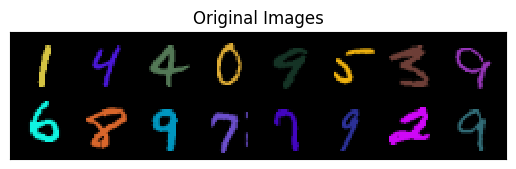

In [ ]:
npimg = make_grid(image_rgb.cpu().data).numpy()
fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title('Original Images')

توانایی مدل در بازسازی تصاویر کاهش یافته است و مدل نمی تواند رنگ تصاویر ورودی را بازسازی کند.

تابع هزینه مدل نیز مقدارش درایپاک های مختلف بزرگتر شده است.